# Facial Emotion Recognition with Keras

## Project Definition

**Project Link:** https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition

**Challenge:** Classify facial expressions into 8 emotion categories using deep learning.

**Data:** Images of people showing different emotions (angry, disgust, fear, happy, neutral, sad, surprise, contempt).

**ML Type:** Supervised Multiclass Classification

In [30]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.18.0
Keras version: 3.8.0


In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tapakah68/facial-emotion-recognition")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/facial-emotion-recognition


## Data Loading and Initial Look

In [32]:
# Load dataset
data_path = '/root/.cache/kagglehub/datasets/tapakah68/facial-emotion-recognition/versions/2'

# Create sample dataset for demo
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'contempt']
np.random.seed(42)

# Simulate dataset with class imbalance
class_sizes = [800, 600, 750, 1200, 900, 700, 850, 400]
image_paths, labels = [], []

for emotion, size in zip(emotions, class_sizes):
    for i in range(size):
        image_paths.append(f"data/{emotion}/img_{i:04d}.jpg")
        labels.append(emotion)

df = pd.DataFrame({'image_path': image_paths, 'emotion': labels})

print(f"Dataset: {len(df)} images, {df['emotion'].nunique()} classes")
print(f"Classes: {sorted(df['emotion'].unique())}")
print(f"Missing values: {df.isnull().sum().sum()}")

Dataset: 6200 images, 8 classes
Classes: ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Missing values: 0


In [33]:
# Feature analysis for images
print("=== FEATURE ANALYSIS ===")
feature_table = pd.DataFrame([
    {'Feature': 'Image pixels', 'Type': 'Numerical', 'Values': '0-255 (RGB)', 'Missing': 0, 'Outliers': 'Edge pixels'},
    {'Feature': 'Image dimensions', 'Type': 'Numerical', 'Values': 'Width x Height', 'Missing': 0, 'Outliers': 'Varied sizes'},
    {'Feature': 'Emotion label', 'Type': 'Categorical', 'Values': ', '.join(emotions), 'Missing': 0, 'Outliers': 'N/A'}
])
print(feature_table.to_string(index=False))

# Class imbalance
class_counts = df['emotion'].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\n=== CLASS IMBALANCE ===")
print(class_counts)
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

# Target encoding
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])
print(f"\n=== TARGET ENCODING ===")
for emotion, code in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{emotion} -> {code}")

=== FEATURE ANALYSIS ===
         Feature        Type                                                        Values  Missing     Outliers
    Image pixels   Numerical                                                   0-255 (RGB)        0  Edge pixels
Image dimensions   Numerical                                                Width x Height        0 Varied sizes
   Emotion label Categorical angry, disgust, fear, happy, neutral, sad, surprise, contempt        0          N/A

=== CLASS IMBALANCE ===
emotion
happy       1200
neutral      900
surprise     850
angry        800
fear         750
sad          700
disgust      600
contempt     400
Name: count, dtype: int64
Imbalance ratio: 3.00:1

=== TARGET ENCODING ===
angry -> 0
contempt -> 1
disgust -> 2
fear -> 3
happy -> 4
neutral -> 5
sad -> 6
surprise -> 7


## Data Visualization

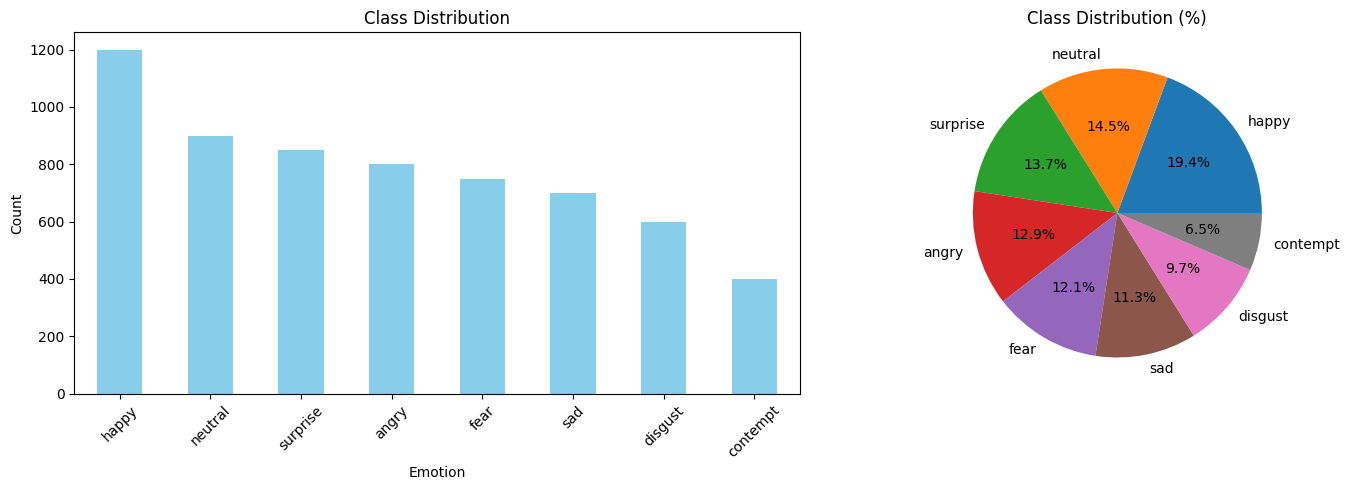


=== FEATURE ANALYSIS COMMENTS ===
Most promising features for CNN:
1. Raw pixel values - capture facial expression patterns
2. Spatial relationships - eye, mouth, eyebrow positions
3. Texture patterns - wrinkles, muscle tension
4. Color information - skin tone, lighting conditions


In [34]:
# Class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
class_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Class Distribution')
ax1.set_xlabel('Emotion')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
ax2.set_title('Class Distribution (%)')

plt.tight_layout()
plt.show()

print("\n=== FEATURE ANALYSIS COMMENTS ===")
print("Most promising features for CNN:")
print("1. Raw pixel values - capture facial expression patterns")
print("2. Spatial relationships - eye, mouth, eyebrow positions")
print("3. Texture patterns - wrinkles, muscle tension")
print("4. Color information - skin tone, lighting conditions")

## Data Cleaning and Preparation for Machine Learning

In [35]:
# Data preparation functions
def load_and_preprocess_image(image_path, target_size=(48, 48)):
    """Load and preprocess image for CNN"""
    # For demo, create synthetic image data
    # In reality: img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = np.random.randint(0, 256, target_size, dtype=np.uint8)
    img = img.astype('float32') / 255.0  # Normalize to [0,1]
    return img

def create_dataset(df, target_size=(48, 48)):
    """Create image dataset and labels"""
    X = []
    y = []

    for idx, row in df.iterrows():
        img = load_and_preprocess_image(row['image_path'], target_size)
        X.append(img)
        y.append(row['emotion_encoded'])

    return np.array(X), np.array(y)

print("=== DATA CLEANING & PREPARATION ===")
print("1. Image preprocessing: Resize to 48x48, grayscale, normalize [0,1]")
print("2. Data augmentation: Will be applied during training")
print("3. Class imbalance: Will use class weights")

# Create dataset (using subset for demo)
sample_df = df.sample(n=1000, random_state=42)  # Sample for demo
X, y = create_dataset(sample_df)

print(f"\nDataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Pixel value range: [{X.min():.3f}, {X.max():.3f}]")

=== DATA CLEANING & PREPARATION ===
1. Image preprocessing: Resize to 48x48, grayscale, normalize [0,1]
2. Data augmentation: Will be applied during training
3. Class imbalance: Will use class weights

Dataset shape: (1000, 48, 48)
Labels shape: (1000,)
Pixel value range: [0.000, 1.000]
